In [ ]:
# @title Instalação de bibliotecas

%%capture
!pip install moviepy
!pip install ultralytics
!pip install kaggle opendatasets

In [ ]:
# @title Importando bibliotecas

import os
import cv2
import csv
import glob
import torch
import ultralytics
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import opendatasets as od
from pydantic import BaseModel
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import clear_output
import moviepy.video.io.ImageSequenceClip
from ultralytics.engine.results import Results
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler


In [ ]:
# @title Obter dataset

PATH = '/content/drive/MyDrive/Materiais do TCC/Teste YOLO/Projeto Canoas/TCC2'

dataset_root = '/content/drive/MyDrive/Dataset_TCC/DATASET MELHORADO (DA)'
pose_list = sorted(os.listdir(dataset_root))

pose_list


['Caido', 'Caminhando', 'Cansado', 'Mao_No_Peito', 'Mao_na_cabeca']

In [ ]:
# @title Remover arquivos que não seja PNG, JPG ou JPEG

for pose in pose_list:
    diretorio = f'{dataset_root}/{pose}'

    # Lista os arquivos no diretório
    arquivos = os.listdir(diretorio)

    # Loop pelos arquivos
    for i, nome_arquivo in enumerate(arquivos):
        # Verifica se a extensão do arquivo não é .jpg, .png ou .jpeg
        _, extensao = os.path.splitext(nome_arquivo)

        if extensao.lower() not in ['.jpg', '.png', '.jpeg']:
            # Constrói o caminho completo para o arquivo
            caminho = os.path.join(diretorio, nome_arquivo)

            # Apagar arquivo indesejado
            os.remove(caminho)


In [ ]:
# @title Carregar o YOLOv8-pose

model = ultralytics.YOLO(model='yolov8x-pose-p6.pt')

100%|██████████| 190M/190M [00:05<00:00, 36.9MB/s]


In [ ]:
# @title Gerando o dataset

class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()


def extract_keypoint(keypoint):
    keypoints = [
        'NOSE', 'LEFT_EYE', 'RIGHT_EYE', 'LEFT_EAR', 'RIGHT_EAR',
        'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
        'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_HIP', 'RIGHT_HIP',
        'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE'
    ]

    result = []
    for point in keypoints:
        x, y = keypoint[getattr(get_keypoint, point)]
        result.extend([x, y])

    return result


def process_image(image_path, pose):
    try:
        # Extrai o nome da imagem do caminho
        image_name = os.path.basename(image_path)

        # Lê a imagem usando o OpenCV
        image = cv2.imread(image_path)

        # Executa a detecção de pessoas
        results = model.predict(image, save=False, conf=0.50)[0]

        # Obtém keypoints e coordenadas das bounding boxes
        keypoints = results.keypoints.xyn.cpu().numpy()

        # Verifica se há apenas uma pessoa detectada
        if len(results.boxes.xyxy) == 1:
            # Filtra keypoints com 17 elementos
            return [(image_name, pose, *extract_keypoint(keypoint)) for keypoint in keypoints if len(keypoint) == 17]

        return []
    except IndexError:
        return []


dataset_csv = []
for pose in pose_list:
    image_paths = glob.glob(f'{dataset_root}/{pose}/*.*')
    for image_path in image_paths:
        dataset_csv.extend(process_image(image_path, pose))

# Define body parts and their coordinates
body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
              'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
              'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
              'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
              ]

# Generate header using list comprehension
header = ['image_name', 'label'] + [f'{part}_{coord}' for part in body_parts for coord in ['x', 'y']]

# Define file path
file_path = os.path.join(PATH, 'keypoints_pose_v1.csv')

# Write to CSV
with open(file_path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)  # write the header
    writer.writerows(dataset_csv)  # write multiple rows


A saída de streaming foi truncada nas últimas 5000 linhas.
0: 832x1280 1 person, 156.5ms
Speed: 6.7ms preprocess, 156.5ms inference, 1.4ms postprocess per image at shape (1, 3, 832, 1280)

0: 896x1280 1 person, 162.2ms
Speed: 9.7ms preprocess, 162.2ms inference, 2.5ms postprocess per image at shape (1, 3, 896, 1280)

0: 896x1280 1 person, 158.1ms
Speed: 7.6ms preprocess, 158.1ms inference, 1.5ms postprocess per image at shape (1, 3, 896, 1280)

0: 768x1280 1 person, 136.8ms
Speed: 3.7ms preprocess, 136.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1280)

0: 896x1280 1 person, 160.0ms
Speed: 7.2ms preprocess, 160.0ms inference, 1.4ms postprocess per image at shape (1, 3, 896, 1280)

0: 896x1280 1 person, 161.1ms
Speed: 7.1ms preprocess, 161.1ms inference, 1.8ms postprocess per image at shape (1, 3, 896, 1280)

0: 960x1280 1 person, 173.4ms
Speed: 7.7ms preprocess, 173.4ms inference, 1.6ms postprocess per image at shape (1, 3, 960, 1280)

0: 896x1280 1 person, 161.6ms
S

In [ ]:
# @title Escrevendo as alterações no arquivo

df = pd.read_csv(PATH + '/keypoints_pose_v1.csv')
df = df.drop('image_name', axis=1)
df.head()


label    nose_x    nose_y  left_eye_x  left_eye_y  right_eye_x  \
0  Caido  0.792430  0.613291    0.799647    0.631989     0.800377   
1  Caido  0.625301  0.288902    0.662422    0.235695     0.596074   
2  Caido  0.372103  0.386051    0.373427    0.341881     0.348586   
3  Caido  0.156863  0.411583    0.154728    0.384514     0.141616   
4  Caido  0.669781  0.656873    0.677087    0.678207     0.685352   

   right_eye_y  left_ear_x  left_ear_y  right_ear_x  ...  right_knee_x  \
0     0.603245    0.778640    0.693841     0.787107  ...      0.559041   
1     0.234829    0.706336    0.238714     0.555535  ...      0.871672   
2     0.367384    0.378351    0.311462     0.305991  ...      0.511068   
3     0.407594    0.160759    0.347576     0.126216  ...      0.314429   
4     0.637484    0.000000    0.000000     0.688933  ...      0.385452   

   right_knee_y  left_ankle_x  left_ankle_y  right_ankle_x  right_ankle_y  \
0      0.439603      0.512550      0.241521       0.528212       0.228444   
1      0.195308      0.967513      0.120665       0.907647       0.081932   
2      0.862256      0.892082      0.604929       0.735559       0.828270   
3      0.535502      0.448568      0.583480       0.391605       0.595416   
4      0.668150      0.309221      0.786041       0.200879       0.686373   

   coord_box_min_x  coord_box_min_y  coord_box_max_x  coord_box_max_y  
0            928.0             64.0           1633.0            842.0  
1            195.0              4.0            640.0            295.0  
2            296.0            154.0           1251.0            668.0  
3              3.0            106.0            295.0            242.0  
4            129.0            269.0           1013.0            705.0  

[5 rows x 39 columns]

In [ ]:
# @title Verificando os tipos dos dados

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             4399 non-null   object 
 1   nose_x            4399 non-null   float64
 2   nose_y            4399 non-null   float64
 3   left_eye_x        4399 non-null   float64
 4   left_eye_y        4399 non-null   float64
 5   right_eye_x       4399 non-null   float64
 6   right_eye_y       4399 non-null   float64
 7   left_ear_x        4399 non-null   float64
 8   left_ear_y        4399 non-null   float64
 9   right_ear_x       4399 non-null   float64
 10  right_ear_y       4399 non-null   float64
 11  left_shoulder_x   4399 non-null   float64
 12  left_shoulder_y   4399 non-null   float64
 13  right_shoulder_x  4399 non-null   float64
 14  right_shoulder_y  4399 non-null   float64
 15  left_elbow_x      4399 non-null   float64
 16  left_elbow_y      4399 non-null   float64


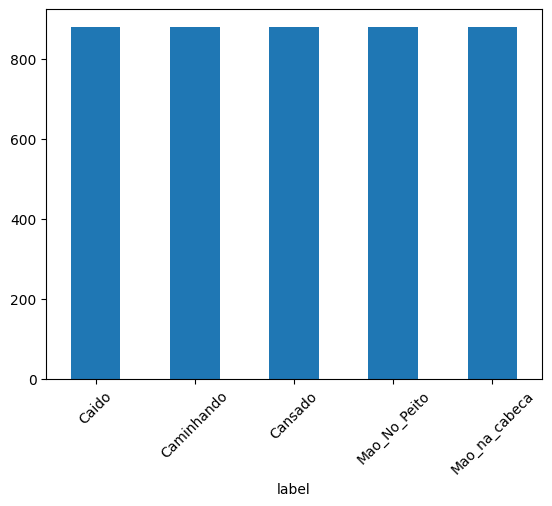

In [ ]:
# @title Exibindo as instâncias coletadas para cada classe

df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()


# Treinando o modelo

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# @title Importando o dataset

df = pd.read_csv(PATH + '/keypoints_pose_v1.csv')
df.head()


image_name  label    nose_x    nose_y  left_eye_x  left_eye_y  \
0  youtuber_11517.png  Caido  0.792430  0.613291    0.799647    0.631989   
1    000000439773.jpg  Caido  0.625301  0.288902    0.662422    0.235695   
2       055050414.jpg  Caido  0.372103  0.386051    0.373427    0.341881   
3    000000494052.jpg  Caido  0.156863  0.411583    0.154728    0.384514   
4       img4_853.jpeg  Caido  0.669781  0.656873    0.677087    0.678207   

   right_eye_x  right_eye_y  left_ear_x  left_ear_y  ...  right_hip_x  \
0     0.800377     0.603245    0.778640    0.693841  ...     0.589738   
1     0.596074     0.234829    0.706336    0.238714  ...     0.771434   
2     0.348586     0.367384    0.378351    0.311462  ...     0.452212   
3     0.141616     0.407594    0.160759    0.347576  ...     0.253522   
4     0.685352     0.637484    0.000000    0.000000  ...     0.466173   

   right_hip_y  left_knee_x  left_knee_y  right_knee_x  right_knee_y  \
0     0.646124     0.543216     0.447671      0.559041      0.439603   
1     0.262907     0.950526     0.257640      0.871672      0.195308   
2     0.698635     0.715847     0.632951      0.511068      0.862256   
3     0.449974     0.360880     0.496519      0.314429      0.535502   
4     0.459130     0.506871     0.766583      0.385452      0.668150   

   left_ankle_x  left_ankle_y  right_ankle_x  right_ankle_y  
0      0.512550      0.241521       0.528212       0.228444  
1      0.967513      0.120665       0.907647       0.081932  
2      0.892082      0.604929       0.735559       0.828270  
3      0.448568      0.583480       0.391605       0.595416  
4      0.309221      0.786041       0.200879       0.686373  

[5 rows x 36 columns]

In [ ]:
# @title Particionando o dataset

# encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Get keypoint dataset
X = df.iloc[:,2:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Número de keypoints de treinamento: ", len(X_train))
print("Número de keypoints de teste: ", len(X_test))

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test


Número de keypoints de treinamento:  3519
Número de keypoints de teste:  880


array([[    0.59094,     0.32967,       0.638, ...,     0.65186,     0.62493,      0.9221],
       [    0.57445,     0.37027,           0, ...,     0.73158,     0.53086,     0.78982],
       [    0.66416,     0.32023,     0.67741, ...,           0,           0,           0],
       ...,
       [    0.48869,     0.33288,     0.50358, ...,           0,           0,           0],
       [    0.58743,     0.31285,     0.59228, ...,     0.81407,     0.53645,     0.80981],
       [    0.50761,     0.37157,     0.52945, ...,           0,           0,           0]])

In [ ]:
# @title DataLoader

class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples


train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

# batch_size = 8
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# @title Montando o Modelo Neural

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out


hidden_size = 512
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))


In [ ]:
# @title Função de perda e Otimizador

learning_rate = 0.001
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

In [ ]:
# @title Função de treino e validação

def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()

    losses = []
    accuracies = []

    loop = tqdm(data_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        losses.append(loss.item())
        accuracies.append(accuracy)

        if phase == 'training':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loop.set_description(f"--- Epoch ({phase}) [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

    return losses[-1:], accuracies[-1:]


In [ ]:
# @title Treinando o modelo

train_losses = []
train_acc = []
test_losses = []
test_acc = []
iter = 0

num_epoch = 100

for epoch in range(num_epoch):
    train_correct = 0
    total1 = 0
    running_loss = 0
    for features, labels in train_loader:
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        if torch.cuda.is_available():
            train_correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            train_correct += (predicted == labels).sum()

    train_accuracy = 100 * train_correct / total1
    train_loss = running_loss / len(train_loader)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)

    test_loss = 0
    correct = 0
    total = 0
    for features, labels in test_loader:
        labels = labels.to(device)
        outputs = model(features)
        loss_t = criterion(outputs,labels)
        test_loss += loss_t.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    test_loss=test_loss / len(test_loader)
    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    test_losses.append(test_loss)

    clear_output(wait=True)

    print(f'{"." * 80}\n--- Epoch (training) [{epoch + 1}/{num_epoch}]: acc={train_accuracy:.2f}, loss={train_loss:.5f}')
    print(f'--- Epoch (validation) [{epoch + 1}/{num_epoch}]: val_acc={accuracy:.2f}, val_loss={test_loss:.5f}')


................................................................................
--- Epoch (training) [100/100]: acc=98.75, loss=0.04744
--- Epoch (validation) [100/100]: val_acc=95.34, val_loss=0.16626


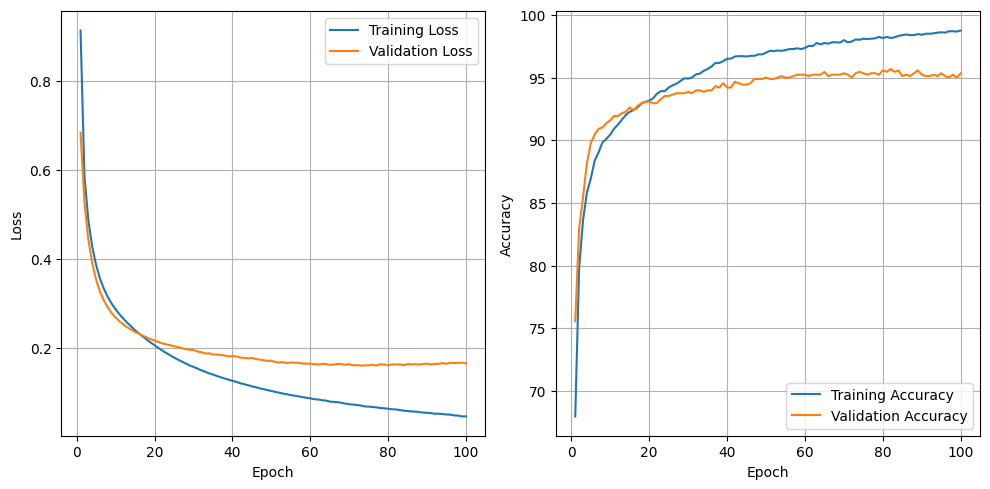

In [ ]:
# @title Plotar as métricas de desempenho

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epoch + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, num_epoch + 1), test_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# @title Teste do modelo

test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions


tensor([4, 1, 4, 2, 3, 3, 1, 0, 1, 0, 3, 1, 3, 4, 3, 0, 2, 1, 0, 1, 1, 3, 2, 1, 3, 0, 0, 4, 0, 0, 4, 1, 0, 2, 0, 4, 4, 3, 4, 1, 3, 3, 2, 1, 1, 0, 0, 4, 1, 4, 3, 1, 3, 0, 1, 3, 4, 2, 0, 2, 1, 4, 0, 3, 4, 3, 4, 4, 2, 3, 0, 3, 4, 4, 4, 0, 4, 4, 0, 2, 1, 4, 0, 2, 0, 1, 0, 0, 3, 4, 1, 3, 3, 0, 4, 1, 0, 2, 4, 4, 3, 1, 3, 3,
        4, 2, 3, 4, 4, 4, 3, 2, 1, 1, 4, 3, 3, 3, 1, 2, 2, 4, 0, 2, 1, 1, 1, 2, 2, 2, 3, 1, 1, 3, 0, 2, 3, 4, 4, 4, 4, 0, 2, 3, 4, 0, 2, 0, 3, 3, 4, 2, 1, 2, 3, 2, 0, 2, 4, 3, 2, 4, 2, 1, 2, 1, 4, 1, 4, 1, 0, 3, 4, 3, 3, 3, 1, 3, 0, 2, 2, 2, 1, 4, 1, 3, 4, 1, 0, 0, 2, 3, 1, 0, 3, 2, 1, 0, 2, 0, 0, 1, 3, 3, 1, 1, 0, 0,
        4, 2, 1, 1, 3, 0, 4, 0, 1, 1, 1, 2, 1, 1, 2, 4, 0, 0, 1, 2, 1, 0, 2, 3, 3, 2, 4, 3, 2, 4, 1, 2, 2, 1, 2, 2, 2, 2, 0, 4, 0, 2, 0, 1, 1, 2, 1, 3, 4, 1, 1, 2, 2, 3, 1, 2, 0, 3, 2, 0, 1, 1, 1, 2, 1, 0, 1, 3, 2, 3, 4, 1, 0, 3, 4, 4, 1, 4, 3, 4, 0, 0, 2, 0, 0, 4, 3, 1, 4, 2, 3, 2, 0, 3, 4, 1, 4, 0, 4, 3, 0, 3, 3, 3,
        0, 2, 4, 0, 2, 1, 2, 3, 1, 3, 3,

In [ ]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))


               precision    recall  f1-score   support

        Caido       0.97      0.95      0.96       176
   Caminhando       0.91      0.97      0.94       176
      Cansado       0.97      0.97      0.97       176
 Mao_No_Peito       0.95      0.96      0.96       176
Mao_na_cabeca       0.97      0.93      0.95       176

     accuracy                           0.95       880
    macro avg       0.95      0.95      0.95       880
 weighted avg       0.95      0.95      0.95       880



In [ ]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm,
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm


Caido  Caminhando  Cansado  Mao_No_Peito  Mao_na_cabeca
Caido            167           6        2             0              1
Caminhando         2         170        0             2              2
Cansado            1           2      170             2              1
Mao_No_Peito       1           4        1           169              1
Mao_na_cabeca      2           4        3             4            163

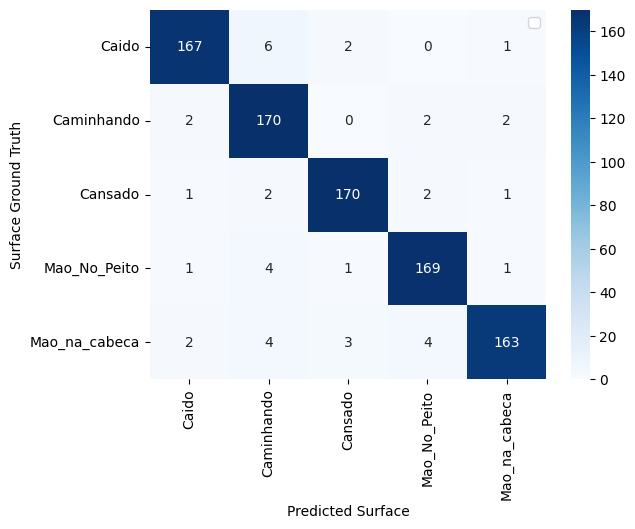

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()

show_confusion_matrix(df_cm)


In [ ]:
# @title Salvando o modelo

PATH_SAVE = PATH + '/pesos_pose_classification_v1.pt'
torch.save(model.state_dict(), PATH_SAVE)


In [ ]:
# @title Testando o modelo

# Define keypoint
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

class DetectKeypoint:
    def __init__(self, yolov8_model='yolov8m-pose'):
        self.yolov8_model = yolov8_model
        self.get_keypoint = GetKeypoint()
        self.__load_model()

    def __load_model(self):
        if not self.yolov8_model.split('-')[-1] == 'pose':
            sys.exit('Model not yolov8 pose')
        self.model = ultralytics.YOLO(model=self.yolov8_model)

    def extract_keypoint(self, keypoint: np.ndarray) -> list:
        keypoints = [
            self.get_keypoint.NOSE, self.get_keypoint.LEFT_EYE, self.get_keypoint.RIGHT_EYE,
            self.get_keypoint.LEFT_EAR, self.get_keypoint.RIGHT_EAR, self.get_keypoint.LEFT_SHOULDER,
            self.get_keypoint.RIGHT_SHOULDER, self.get_keypoint.LEFT_ELBOW, self.get_keypoint.RIGHT_ELBOW,
            self.get_keypoint.LEFT_WRIST, self.get_keypoint.RIGHT_WRIST, self.get_keypoint.LEFT_HIP,
            self.get_keypoint.RIGHT_HIP, self.get_keypoint.LEFT_KNEE, self.get_keypoint.RIGHT_KNEE,
            self.get_keypoint.LEFT_ANKLE, self.get_keypoint.RIGHT_ANKLE
        ]
        return [coord for keypoint_id in keypoints for coord in keypoint[keypoint_id]]

    def get_xy_keypoint(self, results: Results, indice) -> list:
        return [self.extract_keypoint(result_keypoint) for result_keypoint in results.keypoints.xyn.cpu().numpy()][indice]

    def __call__(self, image: np.array) -> Results:
        return self.model.predict(image, save=False, conf=0.85)[0]


class NeuralNet(nn.Module):
    def __init__(
        self,
        input_size = 34,
        hidden_size = 512,
        num_classes = 5
    ):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out


class KeypointClassification:
    def __init__(self, path_model: str):
        """
        Inicializa a classe KeypointClassification.
        :param path_model: Caminho para o modelo pré-treinado.
        """
        self.path_model = path_model
        self.classes = ['Caido', 'Caminhando', 'Cansado', 'Mao_na_cabeca', 'Mao_No_Peito']
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model()

    def load_model(self):
        """
        Carrega o modelo pré-treinado.
        :return: Modelo carregado.
        """
        model = NeuralNet()
        model.load_state_dict(torch.load(self.path_model, map_location=self.device))
        return model

    def __call__(self, input_keypoint):
        """
        Classifica o keypoint de entrada.
        :param input_keypoint: Keypoint a ser classificado.
        :return: Classe prevista para o keypoint.
        """
        if not isinstance(input_keypoint, torch.Tensor):
            input_keypoint = torch.tensor(input_keypoint, dtype=torch.float32)
        out = self.model(input_keypoint)
        _, predict = torch.max(out, -1)
        label_predict = self.classes[predict]
        return label_predict


if __name__ == '__main__':
    keypoint_classification = KeypointClassification(
        path_model = PATH + '/pesos_pose_classification_v1.pt'
    )
    dummy_input = torch.randn(34)
    classification = keypoint_classification(dummy_input)
    print(classification)


Mao_No_Peito


In [ ]:
detection_keypoint = DetectKeypoint()
classification_keypoint = KeypointClassification(
    PATH + '/pesos_pose_classification_v1.pt'
)


100%|██████████| 50.8M/50.8M [00:00<00:00, 141MB/s]


In [ ]:
# @title Imagem

def img_classification(image):
    results = detection_keypoint(image)
    image_draw = results.plot(boxes=False)

    for box, results_keypoint in zip(results.boxes.xyxy.cpu().numpy(),
                                     [detection_keypoint.get_xy_keypoint(results, num) for num in range(len(results))]):
        x_min, y_min, x_max, y_max = map(int, box)
        image_draw = cv2.rectangle(
            image_draw,
            (x_min, y_min), (x_max, y_max),
            (0, 0, 255), 2
            )

        results_classification = classification_keypoint(results_keypoint)
        classification_text = results_classification.upper().replace('_', ' ')
        image_draw = cv2.rectangle(
            image_draw,
            (x_min, y_min), (x_max, y_max),
            (0, 0, 255), 2
            )
        (w, h), _ = cv2.getTextSize(
            classification_text,
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
            )
        image_draw = cv2.rectangle(
            image_draw,
            (x_min, y_min - 20), (x_min + w, y_min),
            (0, 0, 255), -1
            )
        cv2.putText(
            image_draw,
            f'{classification_text}',
            (x_min, y_min - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (255, 255, 255),
            thickness=2
            )
        print(f'Keypoint classification: {results_classification}')

    return image_draw



0: 448x640 1 person, 2411.7ms
Speed: 17.6ms preprocess, 2411.7ms inference, 27.2ms postprocess per image at shape (1, 3, 448, 640)
Keypoint classification: Caminhando


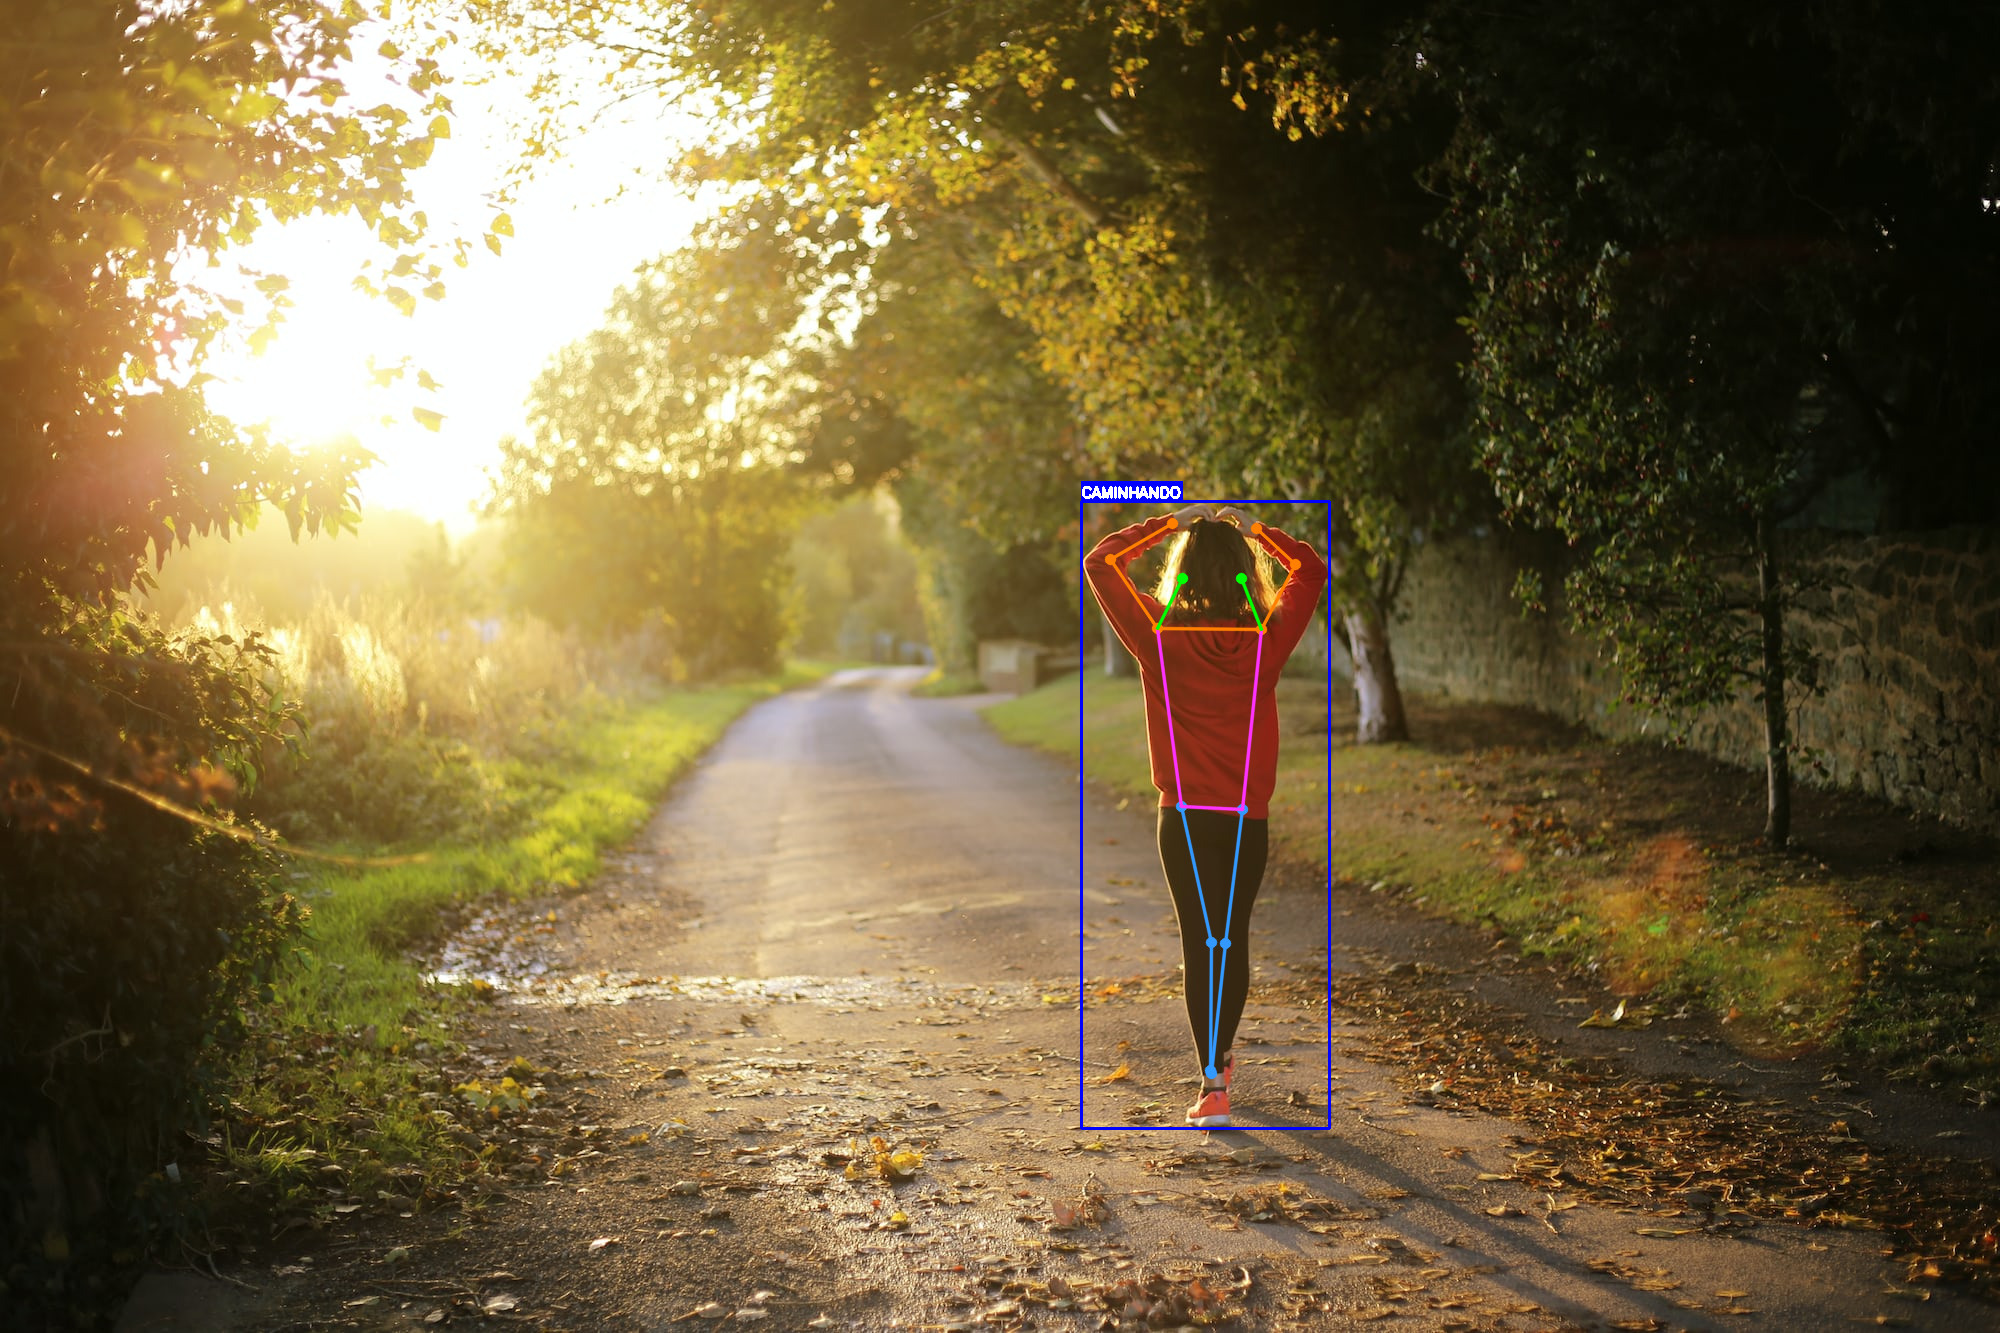

In [ ]:
image = cv2.imread('/content/0037.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_draw = img_classification(image)

Image.fromarray(image_draw)


In [ ]:
# @title Vídeo
def save_img(image, num_img):
    image_draw = img_classification(image)

    cv2.imwrite(f'{PATH}/teste/image{num_img}.png', image_draw)


def name_img(image, num_img):
    image_draw = img_classification(image)

    img = f'image{num_img}.png'

    if cv2.imwrite(img, image_draw):
        return img


In [ ]:
from google.colab.patches import cv2_imshow

# Open the video file
video_path = '/content/drive/MyDrive/Materiais do TCC/Teste YOLO/Gato.mp4'
cap = cv2.VideoCapture(video_path)

num_img = 0
image_files = []

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        num_img += 1

        image_files.append(name_img(frame, num_img))

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=30)
clip.write_videofile(PATH + '/Predições3.mp4')



0: 384x640 1 person, 1134.5ms
Speed: 7.6ms preprocess, 1134.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: Mao_na_cabeca

0: 384x640 1 person, 1045.4ms
Speed: 5.0ms preprocess, 1045.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: Mao_na_cabeca

0: 384x640 1 person, 1635.6ms
Speed: 8.9ms preprocess, 1635.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: Mao_na_cabeca

0: 384x640 1 person, 1636.9ms
Speed: 5.2ms preprocess, 1636.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: Mao_na_cabeca

0: 384x640 1 person, 1657.4ms
Speed: 4.3ms preprocess, 1657.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: Mao_na_cabeca

0: 384x640 1 person, 1055.3ms
Speed: 4.5ms preprocess, 1055.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Keypoint classification: 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Materiais do TCC/Teste YOLO/Projeto Canoas/TCC2/Predições3.mp4
